In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler #undersampler
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
sensor_df = pd.read_csv("C:/Users/aiman/Downloads/sensor_df.csv")
driver_df = pd.read_csv("C:/Users/aiman/Downloads/driver_df.csv")
safety_df = pd.read_csv("C:/Users/aiman/Downloads/safety_status.csv")


In [87]:
# Merge datasets and drop duplicates booking key
df = pd.merge(safety_df, sensor_df, on='booking_key', how='inner')
df = pd.merge(df, driver_df, on='driver_key', how='inner')
df = df.drop_duplicates(subset=['booking_key'])
df

,booking_key,driver_key,dangerous,sensor_key,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,...,gyro_z,seconds,speed,driver_name,date_of_birth,years_of_experience,gender,car_brand,car_model_year,driver_rating
0,0,359,0,11084,8.0,286.468414,-1.467249,-8.900690,-0.949854,0.128197,...,-0.152818,1172.0,15.456474,Jemmie Cardew,1970-05-12,9,Female,Mercedes-Benz,2003,4.7
454,85899345998,359,1,5590,8.0,237.000000,0.184359,9.632168,-3.533950,0.098008,...,0.004282,320.0,10.837437,Jemmie Cardew,1970-05-12,9,Female,Mercedes-Benz,2003,4.7
788,103079215267,359,0,13852,3.9,172.000000,-0.632000,0.000000,3.179000,0.009720,...,-0.238419,379.0,15.363944,Jemmie Cardew,1970-05-12,9,Female,Mercedes-Benz,2003,4.7
965,146028888255,359,1,18052,15.0,21.664656,-0.402103,-8.655750,-5.474667,-0.009530,...,-0.028586,183.0,6.160989,Jemmie Cardew,1970-05-12,9,Female,Mercedes-Benz,2003,4.7
1725,214748364829,359,0,6305,4.0,44.483086,0.637921,-9.757083,-2.846869,0.010120,...,-0.026053,83.0,14.699432,Jemmie Cardew,1970-05-12,9,Female,Mercedes-Benz,2003,4.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7468203,1365799600134,169,0,62700,10.0,234.960953,0.325989,-9.735400,-2.760587,0.020391,...,0.018390,97.0,7.890000,Marylou Yurkin,1981-12-08,21,Female,Audi,2006,4.9
7468288,1477468749997,169,0,1764,3.9,12.000000,0.883487,8.930645,0.876305,0.086743,...,0.098960,1192.0,9.074968,Marylou Yurkin,1981-12-08,21,Female,Audi,2006,4.9
7468850,1606317768776,169,0,25777,4.0,156.000000,-0.624906,9.747093,2.300898,-0.067855,...,-0.009847,160.0,9.727875,Marylou Yurkin,1981-12-08,21,Female,Audi,2006,4.9
7469213,1623497638020,169,0,3231,4.0,9.000000,0.083800,8.870789,5.719923,-0.077928,...,-0.062719,405.0,5.369940,Marylou Yurkin,1981-12-08,21,Female,Audi,2006,4.9


In [88]:
# Create new column called Dangerous_percentage
# It is the percentage of dangerous trips for each driver
dangerous_percentage = df.groupby('driver_key')['dangerous'].sum() / df.groupby('driver_key')['dangerous'].count() * 100

# Create a new DataFrame to display the results
result_df = pd.DataFrame({
    'driver_key': dangerous_percentage.index,
    'dangerous_percentage': dangerous_percentage.values
})
print(result_df)

In [89]:
# See drivers dangerous percentage above 20
result_df_filtered = result_df[result_df['dangerous_percentage'] > 20]

# Display the filtered result
print(result_df_filtered)
print(len(result_df_filtered))

In [90]:
# Label drivers that have dangerous percentage above 20 as 1 - dangerous. If below 20, label as 0 - safe
df = pd.merge(df, result_df, on='driver_key', how='inner')
df['dangerous'] = df['dangerous_percentage'].apply(lambda x: 1 if x > 20 else 0)
# Drop duplicate driver_Key
df = df.drop_duplicates(subset=['driver_key'])
# Feature selection - Drop collumns that are useless to predict dangerous drivers
columns_to_drop = ['booking_key', 'driver_key','sensor_key','acceleration_x','acceleration_y','acceleration_z','accuracy','bearing','gyro_x','gyro_y','gyro_z','driver_name','seconds','speed']
df = df.drop(columns=columns_to_drop)
df

In [91]:
# LabelEncoder for categorical datatypes
label_encoder = LabelEncoder()
label_encoder2 = LabelEncoder()

df['date_of_birth'] = df['date_of_birth'].str[:4].astype(int)

df['gender'] = label_encoder.fit_transform(df['gender'])
df['car_brand'] = label_encoder2.fit_transform(df['car_brand'])

gender_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
car_brand_mapping = dict(zip(label_encoder2.classes_, label_encoder2.transform(label_encoder2.classes_)))

# Print the mappings
print("Gender mapping:", gender_mapping)
print("Car brand mapping:", car_brand_mapping)

Gender mapping: {'Female': 0, 'Male': 1}
Car brand mapping: {'Audi': 0, 'BMW': 1, 'Honda': 2, 'Hyundai': 3, 'Kia': 4, 'Lexus': 5, 'Mazda': 6, 'Mercedes-Benz': 7, 'Mitsubishi': 8, 'Nissan': 9, 'Toyota': 10, 'Volkswagen': 11}


In [92]:
X = df.drop(['dangerous','dangerous_percentage'], axis=1)
y=df['dangerous']
#X

In [102]:
X.to_csv('data.csv', index=False)
# Confirm that the file is saved
print("DataFrame X has been saved to data.csv")

DataFrame X has been saved to data.csv


Standardization of X


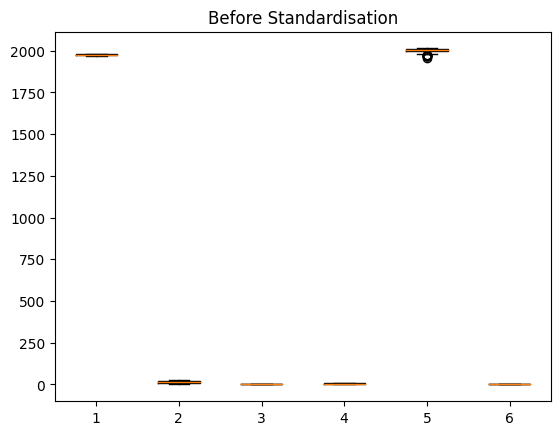

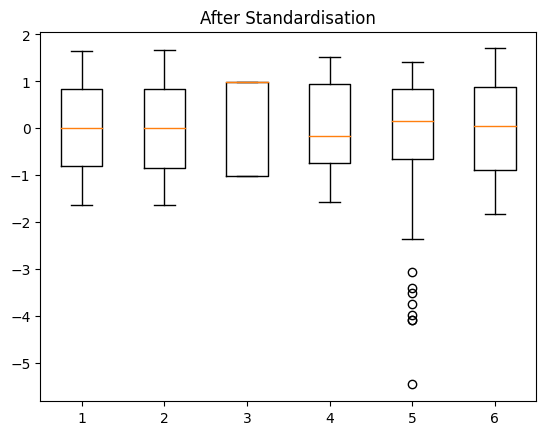

In [93]:
#function StandardScaler before and after
# Scale data
def aftstd(data):
    std_scaler = StandardScaler()
    df_std = std_scaler.fit(data)
    df_std = df_std.transform(data)
    plt.boxplot(df_std)
    plt.title('After Standardisation')
    plt.show()
    return df_std

def befstd(data):
    plt.boxplot(data)
    plt.title('Before Standardisation')
    plt.show()



to_standardize = X

print("Standardization of X")
#Before standardization
befstd(to_standardize)
# standardization
X_scaled = pd.DataFrame(aftstd(to_standardize))

In [94]:
# Check class imbalance
counter = Counter(y)
print(counter)


Counter({1: 370, 0: 130})


In [95]:
# Baseline model
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.75, random_state=42)
# define model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
# make prediction
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred,
      target_names=['class 0', 'class 1']))
print(f'\nConfusion matrix: \n{confusion_matrix(y_test, y_pred)}')

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00        32
     class 1       0.74      1.00      0.85        93

    accuracy                           0.74       125
   macro avg       0.37      0.50      0.43       125
weighted avg       0.55      0.74      0.63       125


Confusion matrix: 
[[ 0 32]
 [ 0 93]]


C:\Users\aiman\anaconda4\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aiman\anaconda4\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aiman\anaconda4\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [96]:
# Deal with class imbalance with random over sampler
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_scaled, y)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, train_size=0.75, random_state=42)
# define model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
# make prediction
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred,
      target_names=['class 0', 'class 1']))
print(f'\nConfusion matrix: \n{confusion_matrix(y_test, y_pred)}')
print(len(X_train))

              precision    recall  f1-score   support

     class 0       0.47      0.78      0.59        79
     class 1       0.69      0.35      0.46       106

    accuracy                           0.54       185
   macro avg       0.58      0.57      0.53       185
weighted avg       0.59      0.54      0.52       185


Confusion matrix: 
[[62 17]
 [69 37]]
555


In [13]:
# For loop to calculate accuracy score for all the models to determine which to use
# We are taking the top 3 best scoring models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB  # Import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming you have your data and labels stored in X and y

models = {
    "KNN": KNeighborsClassifier(),
    "LogReg": LogisticRegression(),
    "RF": RandomForestClassifier(),
    "SVM": SVC(),
    "AdaBoost": AdaBoostClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "MLP": MLPClassifier(),
    "GaussianNB": GaussianNB()  # Include GaussianNB in the models dictionary
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} accuracy score: {accuracy:.4f}")


KNN accuracy score: 0.6000
LogReg accuracy score: 0.5351
RF accuracy score: 0.8811
SVM accuracy score: 0.5405
AdaBoost accuracy score: 0.6108
GradientBoosting accuracy score: 0.7514
MLP accuracy score: 0.6432
GaussianNB accuracy score: 0.5243


C:\Users\aiman\anaconda4\envs\gpu_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [65]:
# Baseline random forest classifier model
lr_model = RandomForestClassifier(random_state=42)
lr_model.fit(X_train, y_train)
# make prediction
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred,
      target_names=['class 0', 'class 1']))
print(f'\nConfusion matrix: \n{confusion_matrix(y_test, y_pred)}')
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

              precision    recall  f1-score   support

     class 0       0.80      0.84      0.82        79
     class 1       0.87      0.85      0.86       106

    accuracy                           0.84       185
   macro avg       0.84      0.84      0.84       185
weighted avg       0.84      0.84      0.84       185


Confusion matrix: 
[[66 13]
 [16 90]]
Accuracy: 0.8432432432432433


In [62]:
# Deal with outliers
from sklearn.ensemble import IsolationForest
print('Initial shape of the training dataset', X_train.shape, y_train.shape)

# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1,random_state=42)
x_out = iso.fit_predict(X_train)

# select all rows that are not outliers
mask = (x_out != -1)
X_train_out, y_train_out = X_train[mask], y_train[mask]

# summarize the shape of the updated training dataset
print('Shape of the training dataset after removing outliers', X_train_out.shape, y_train_out.shape)

# Instantiate and fit the classifier
lr_model = RandomForestClassifier(random_state=42)
lr_model.fit(X_train_out, y_train_out)
# make prediction
y_pred = lr_model.predict(X_test)

# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'*********** Random Forest Classifier Accuracy: {accuracy*100:.2f}% *************')

Initial shape of the training dataset (555, 6) (555,)
Shape of the training dataset after removing outliers (499, 6) (499,)
*********** Random Forest Classifier Accuracy: 78.92% *************


In [64]:
# Deal with outliers
from sklearn.svm import OneClassSVM
print('Initial shape of the training dataset:', X_train_out.shape, y_train_out.shape)

# Identify outliers in the training dataset using OneClassSVM
svm = OneClassSVM(nu=0.1)
outlier_labels = svm.fit_predict(X_train_out)

# Select all rows that are not outliers
X_train_cleaned = X_train_out[outlier_labels != -1]
y_train_cleaned = y_train_out[outlier_labels != -1]

# Summarize the shape of the updated training dataset
print('Shape of the training dataset after removing outliers:', X_train_cleaned.shape, y_train_cleaned.shape)

# Fit the logistic regression model
lr_model = RandomForestClassifier(random_state=42)
lr_model.fit(X_train_cleaned, y_train_cleaned)
# make prediction
y_pred = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'******* Logistic Regression Accuracy after outlier removal: {accuracy*100:.2f}% **********')
# Outliers decreased performance. Thus we will not be removing them

Initial shape of the training dataset: (499, 6) (499,)
Shape of the training dataset after removing outliers: (425, 6) (425,)
******* Logistic Regression Accuracy after outlier removal: 74.59% **********


In [15]:
# Hyperparameter tuning for random forest classifier
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

# Initialize Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", random_search.best_params_)


Best parameters: {'bootstrap': False, 'class_weight': None, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 110}
Test Accuracy: 0.8648648648648649


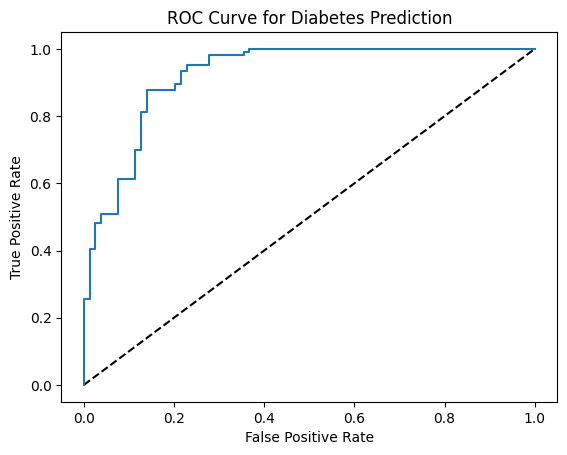

              precision    recall  f1-score   support

     class 0       0.84      0.85      0.84        79
     class 1       0.89      0.88      0.88       106

    accuracy                           0.86       185
   macro avg       0.86      0.86      0.86       185
weighted avg       0.87      0.86      0.86       185


Confusion matrix: 
[[67 12]
 [13 93]]
Test Accuracy: 0.8648648648648649


In [19]:
# Evaluate on test set with the best params

best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred_probs = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Diabetes Prediction')
plt.show()

print(classification_report(y_test, y_pred,
      target_names=['class 0', 'class 1']))
print(f'\nConfusion matrix: \n{confusion_matrix(y_test, y_pred)}')
print("Test Accuracy:", accuracy)
print(f'\nROC accuracy score: {roc_auc_score(ytest, y_pred_probs)}')

In [20]:
# Baseline gradient boosting classifier
lr_model = GradientBoostingClassifier(random_state=42)
lr_model.fit(X_train, y_train)
# make prediction
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred,
      target_names=['class 0', 'class 1']))
print(f'\nConfusion matrix: \n{confusion_matrix(y_test, y_pred)}')
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

              precision    recall  f1-score   support

     class 0       0.67      0.84      0.74        79
     class 1       0.85      0.69      0.76       106

    accuracy                           0.75       185
   macro avg       0.76      0.76      0.75       185
weighted avg       0.77      0.75      0.75       185


Confusion matrix: 
[[66 13]
 [33 73]]
Accuracy: 0.7513513513513513


In [34]:
# Hyperparameter for gradient boosting classifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'subsample': [0.8, 1.0]
}

# Initialize Gradient Boosting classifier
gb = GradientBoostingClassifier(random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)


Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150, 'subsample': 1.0}


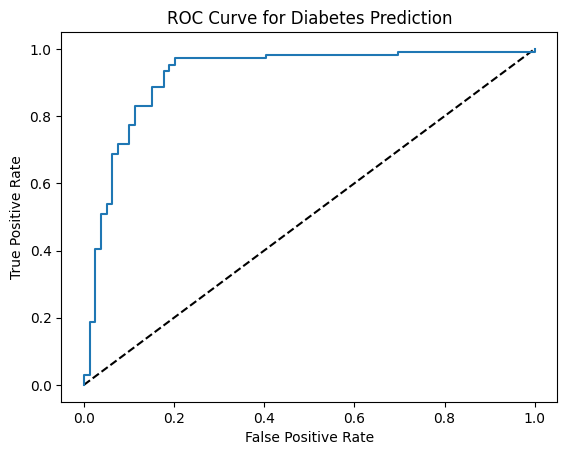

              precision    recall  f1-score   support

     class 0       0.82      0.85      0.83        79
     class 1       0.88      0.86      0.87       106

    accuracy                           0.85       185
   macro avg       0.85      0.85      0.85       185
weighted avg       0.86      0.85      0.85       185


Confusion matrix: 
[[67 12]
 [15 91]]
Test Accuracy: 0.8540540540540541

ROC accuracy score: 0.919035108669692


In [35]:
# Evaluate on test set with best params
best_gb = grid_search.best_estimator_
y_pred = best_gb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred_probs = best_gb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Diabetes Prediction')
plt.show()

print(classification_report(y_test, y_pred,
      target_names=['class 0', 'class 1']))
print(f'\nConfusion matrix: \n{confusion_matrix(y_test, y_pred)}')
print("Test Accuracy:", accuracy)
print(f'\nROC accuracy score: {roc_auc_score(y_test, y_pred_probs)}')

In [97]:
# Baseline MLP classifier model
lr_model = MLPClassifier(random_state=42)
lr_model.fit(X_train, y_train)
# make prediction
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred,
      target_names=['class 0', 'class 1']))
print(f'\nConfusion matrix: \n{confusion_matrix(y_test, y_pred)}')
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

              precision    recall  f1-score   support

     class 0       0.54      0.70      0.61        79
     class 1       0.71      0.57      0.63       106

    accuracy                           0.62       185
   macro avg       0.63      0.63      0.62       185
weighted avg       0.64      0.62      0.62       185


Confusion matrix: 
[[55 24]
 [46 60]]
Accuracy: 0.6216216216216216


C:\Users\aiman\anaconda4\envs\gpu_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [26]:
# Hyperparameter tuning MLP classifier model
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 300, 400],
    'early_stopping': [True, False],
    'validation_fraction': [0.1, 0.2, 0.3]
}

# Initialize MLP classifier
mlp = MLPClassifier(random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)


Best parameters: {'activation': 'logistic', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'lbfgs', 'validation_fraction': 0.1}
Test Accuracy: 0.7783783783783784


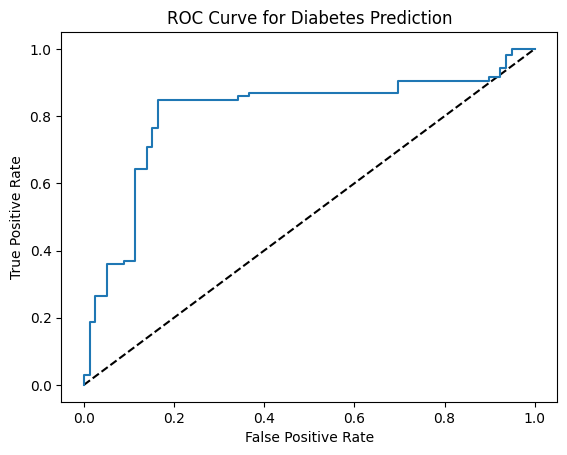

              precision    recall  f1-score   support

     class 0       0.70      0.85      0.77        79
     class 1       0.87      0.73      0.79       106

    accuracy                           0.78       185
   macro avg       0.78      0.79      0.78       185
weighted avg       0.79      0.78      0.78       185


Confusion matrix: 
[[67 12]
 [29 77]]
Test Accuracy: 0.7783783783783784

ROC accuracy score: 0.8066634822068307


In [31]:
# Evaluate on test set with best params
best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred_probs = best_mlp.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Diabetes Prediction')
plt.show()

print(classification_report(y_test, y_pred,
      target_names=['class 0', 'class 1']))
print(f'\nConfusion matrix: \n{confusion_matrix(y_test, y_pred)}')
print("Test Accuracy:", accuracy)
print(f'\nROC accuracy score: {roc_auc_score(y_test, y_pred_probs)}')

In [46]:
# Best params for all the models
best_params_rf = {'bootstrap': False,
                  'class_weight': None,
                   'max_depth': 30,
                   'max_features': 'log2',
                   'min_samples_leaf': 1,
                   'min_samples_split': 6,
                   'n_estimators': 110,
                   'random_state':42}

best_params_gb =  {'learning_rate': 0.2,
                   'max_depth': 5,
                   'max_features': 'sqrt',
                   'min_samples_leaf': 1,
                   'min_samples_split': 5,
                   'n_estimators': 150,
                   'subsample': 1.0,
                   'random_state':42}  
    
best_params_mlp = {'activation': 'logistic',
                   'alpha': 0.001,
                   'early_stopping': True,
                   'hidden_layer_sizes': (100,),
                   'learning_rate': 'constant',
                   'max_iter': 200,
                   'solver': 'lbfgs',
                   'validation_fraction': 0.1,
                   'random_state':42}

In [71]:
# MLFlow to track and monitor machine learning cycles
import mlflow
mlflow.set_experiment(experiment_id="0")
with mlflow.start_run():
    mlflow.set_experiment(experiment_id="0")
    # Log parameters for Random Forest Classifier
    for param_name, param_value in best_params_rf.items():
        mlflow.log_param(f"rf_{param_name}", param_value)

    rf_classifier = RandomForestClassifier(**best_params_rf)
    rf_classifier.fit(X_train, y_train)
    y_pred_rf = rf_classifier.predict(X_test)

    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    y_pred_proba_rf = rf_classifier.predict_proba(X_test)
    roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf[:, 1], multi_class='ovr')
    
    mlflow.log_metric("roc_auc_rf", roc_auc_rf)
    mlflow.log_metric("accuracy_rf", accuracy_rf)
    
    mlflow.sklearn.log_model(rf_classifier, "random_forest_model")

    # Log parameters for Logistic Regression
    for param_name, param_value in best_params_gb.items():
        mlflow.log_param(f"gb_{param_name}", param_value)

    gb_classifier = GradientBoostingClassifier(**best_params_gb)
    gb_classifier.fit(X_train, y_train)
    y_pred_gb = gb_classifier.predict(X_test)
    
    y_pred_proba_gb = gb_classifier.predict_proba(X_test)
    roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb[:, 1], multi_class='ovr')
    accuracy_gb = accuracy_score(y_test, y_pred_gb)
    
    mlflow.log_metric("roc_auc_gb", roc_auc_gb)
    mlflow.log_metric("accuracy_gb", accuracy_gb)

    mlflow.sklearn.log_model(gb_classifier, "gradient_boosting_model")
    
    for param_name, param_value in best_params_mlp.items():
        mlflow.log_param(f"mlp_{param_name}", param_value)

    mlp_classifier = MLPClassifier(**best_params_mlp)
    mlp_classifier.fit(X_train, y_train)
    y_pred_mlp = mlp_classifier.predict(X_test)
    
    accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
    y_pred_proba_mlp = mlp_classifier.predict_proba(X_test)
    roc_auc_mlp = roc_auc_score(y_test, y_pred_proba_mlp[:, 1], multi_class='ovr')
    
    mlflow.log_metric("roc_auc_mlp", roc_auc_mlp)
    mlflow.log_metric("accuracy_mlp", accuracy_mlp)

    mlflow.sklearn.log_model(mlp_classifier, "MLP_classifier_model")


C:\Users\aiman\anaconda4\envs\gpu_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\aiman\anaconda4\envs\gpu_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
C:\Users\aiman\anaconda4\envs\gpu_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid us